In [1]:
# === Auto-install & loading cell ===
import sys
import subprocess
import importlib
import time

t0 = time.time()

def install_and_import(pkg_name, import_name=None, alias=None):
    """
    pkg_name   : nom pour pip
    import_name: nom du module à importer (si différent)
    alias      : alias dans le namespace
    """
    import_name = import_name or pkg_name
    try:
        module = importlib.import_module(import_name)
        print(f"✔ {pkg_name} already installed")
    except ImportError:
        print(f"⬇ Installing {pkg_name}...")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", pkg_name],
            stdout=subprocess.DEVNULL
        )
        module = importlib.import_module(import_name)
        print(f"✔ {pkg_name} installed")

    if alias:
        globals()[alias] = module
    else:
        globals()[import_name] = module


# ===== Core libs =====
install_and_import("numpy", alias="np")
install_and_import("pandas", alias="pd")
install_and_import("matplotlib", "matplotlib.pyplot", alias="plt")

# ===== SciPy / Stats =====
install_and_import("scipy")
from scipy.stats import poisson, gamma, nbinom
from scipy.special import logsumexp

install_and_import("statsmodels")
from statsmodels.tsa.stattools import acf

# ===== Utils =====
install_and_import("numba")
from numba import njit

install_and_import("tqdm")
from tqdm import trange

# ===== Standard libs (no install needed) =====
import math
from math import lgamma
import os
import time

# ===== Custom modules (assumed local) =====
import utils.cox_simulation as cox
import utils.plots as pl
import utils.exact_filter as ef


print(f"\n🚀 Environment ready in {time.time() - t0:.2f}s")


✔ numpy already installed
✔ pandas already installed
✔ matplotlib already installed
✔ scipy already installed
✔ statsmodels already installed
✔ numba already installed
✔ tqdm already installed

🚀 Environment ready in 1.71s


In [2]:
TRUE_PARAMS = {"phi": 0.9, "nu": 2.5, "c": 0.2}
T_sim = 3000

sim = cox.CoxProcessSimulation(T=T_sim, **TRUE_PARAMS, seed=123)

y, h, z, lam = sim.simulate(init="burnin",burn_in=500, h0=1.0, return_lambda=True)

print("Simulation finished.")
print(f"Mean(y) = {y.mean():.3f}")
print(f"Mean(h) = {h.mean():.3f}")
print(f"Max(z)  = {z.max()}")

Simulation finished.
Mean(y) = 5.049
Mean(h) = 4.985
Max(z)  = 97


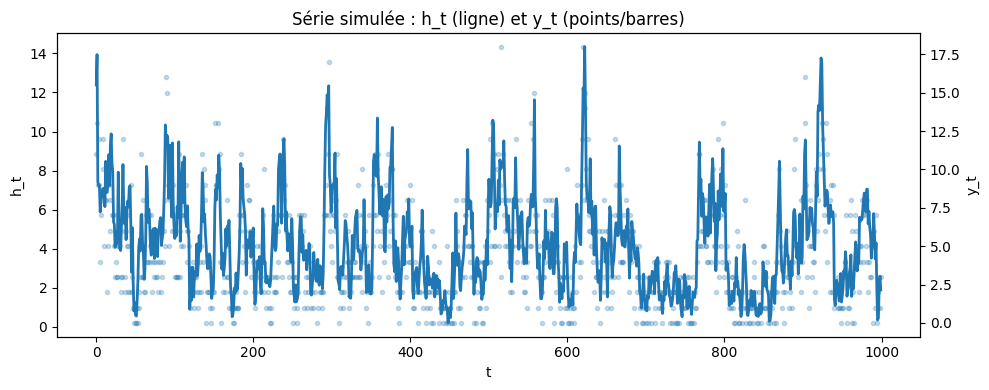

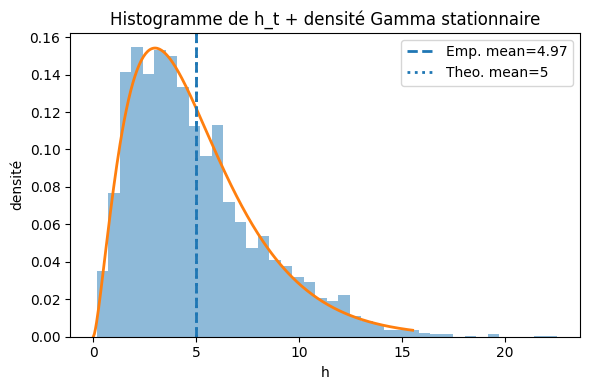

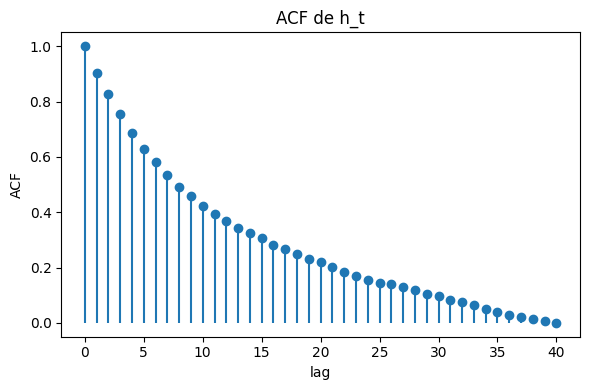

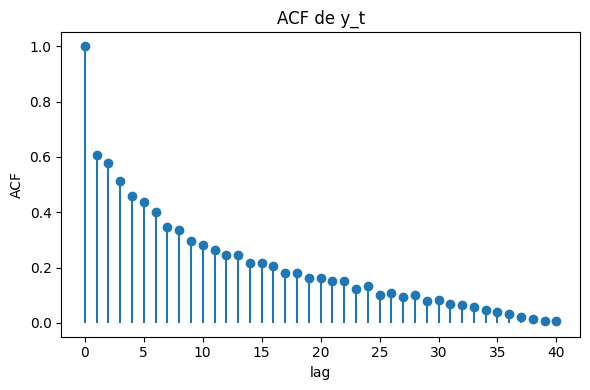

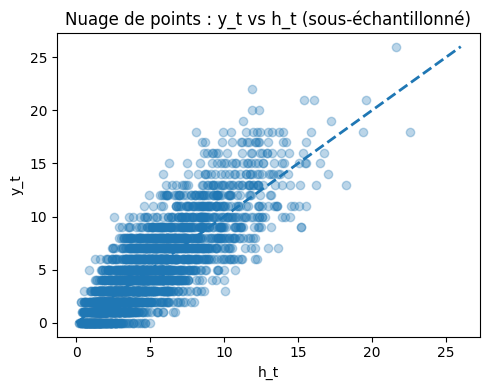

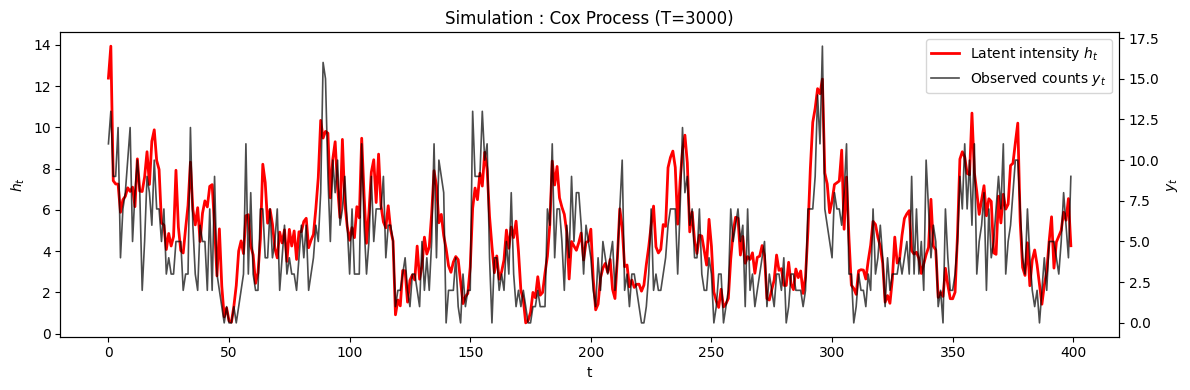

In [3]:
pl.plot_time_series(y, h, T_show=1000, start=0, use_bars=False)
pl.plot_histogram_h(h, nu=TRUE_PARAMS["nu"], phi=TRUE_PARAMS["phi"], c=TRUE_PARAMS["c"], burn=200)
pl.plot_acf_h(h, lags=40, burn=200)
pl.plot_acf_y(y, lags=40, burn=200)
pl.plot_scatter_y_h(y, h, max_points=3000)
pl.plot_overlay_clean(y, h, T_show=400, start=0)

In [3]:
# Initialisation du Filtre Exact avec les données simulées
# On prend une marge de sécurité pour Z afin d'éviter les erreurs de troncature
# si le MCMC explore des paramètres à forte variance.
Z_trunc_val = int(z.max() * 1.5) + 20 
print(f"Initialisation du Filtre Exact avec Z_trunc={Z_trunc_val}")
exact_filter_instance = ef.ExactFilter(y, Z_trunc=Z_trunc_val)

Initialisation du Filtre Exact avec Z_trunc=165


In [4]:
import numpy as np
import math
from numba import njit
from utils.exact_filter import _exact_filter_loglik


# ==============================================================================
# 1. HELPER FUNCTIONS (Log-PDFs compatibles Numba)
# ==============================================================================

@njit
def _logpdf_beta(x, a, b):
    # Beta(a, b): const * x^(a-1) * (1-x)^(b-1)
    if x <= 0 or x >= 1:
        return -1e10 # -inf approx
    return ((a - 1.0) * math.log(x) + 
            (b - 1.0) * math.log(1.0 - x) + 
            math.lgamma(a + b) - math.lgamma(a) - math.lgamma(b))

@njit
def _logpdf_gamma(x, a, scale):
    # Gamma(shape=a, scale=s): 1/(s^a Gamma(a)) * x^(a-1) * exp(-x/s)
    if x <= 0:
        return -1e10
    return ((a - 1.0) * math.log(x) - 
            x / scale - 
            a * math.log(scale) - 
            math.lgamma(a))

@njit
def _logpdf_invgamma(x, a, scale):
    # InvGamma(a, scale): (scale^a / Gamma(a)) * x^(-a-1) * exp(-scale/x)
    if x <= 0:
        return -1e10
    return (a * math.log(scale) - 
            math.lgamma(a) - 
            (a + 1.0) * math.log(x) - 
            scale / x)

# ==============================================================================
# 2. LOGIQUE MCMC BAS NIVEAU (Full Numba)
# ==============================================================================

@njit
def _transform_params(phi, nu, c):
    """Contraint -> Non-contraint"""
    phi_unc = math.log(phi / (1.0 - phi))
    nu_unc = math.log(nu - 1.0)
    c_unc = math.log(c)
    return np.array([phi_unc, nu_unc, c_unc])

@njit
def _inv_transform_params(params_unc):
    """Non-contraint -> Contraint"""
    phi = 1.0 / (1.0 + math.exp(-params_unc[0]))
    nu = 1.0 + math.exp(params_unc[1])
    c = math.exp(params_unc[2])
    return phi, nu, c

@njit
def _log_prior_fast(phi, nu, c):
    """
    Priors hardcodés (identiques à votre version précédente):
    phi ~ Beta(20, 1.5)
    nu-1 ~ Gamma(2, 1)
    c ~ InvGamma(2.5, 0.1)
    """
    if not (0 < phi < 1) or nu <= 1 or c <= 0:
        return -1e10

    lp_phi = _logpdf_beta(phi, 20.0, 1.5)
    lp_nu = _logpdf_gamma(nu - 1.0, 2.0, 1.0)
    lp_c = _logpdf_invgamma(c, 2.5, 0.1)
    
    return lp_phi + lp_nu + lp_c

@njit
def _run_mcmc_kernel(y, Z, start_params_unc, n_samples, proposal_std):
    """
    Le coeur du MCMC: boucle entièrement compilée.
    """
    n_params = 3
    chain_unc = np.zeros((n_samples, n_params))
    chain_constr = np.zeros((n_samples, n_params))
    
    # --- Initialisation ---
    current_unc = start_params_unc.copy()
    phi, nu, c = _inv_transform_params(current_unc)
    
    # 1. Prior
    lp_curr = _log_prior_fast(phi, nu, c)
    
    # 2. Likelihood (Appel à la fonction optimisée existante)
    ll_curr, _ = _exact_filter_loglik(y, Z, phi, nu, c)
    
    # 3. Jacobien (pour l'espace transformé)
    log_det_J_curr = math.log(phi*(1.0-phi)) + math.log(nu-1.0) + math.log(c)
    
    log_prob_curr = ll_curr + lp_curr + log_det_J_curr
    
    accepted = 0
    
    for i in range(n_samples):
        # --- Proposition ---
        # Random walk gaussien sur l'espace non contraint
        proposal_unc = np.empty(3)
        for k in range(3):
            proposal_unc[k] = current_unc[k] + np.random.normal(0, proposal_std[k])
            
        phi_p, nu_p, c_p = _inv_transform_params(proposal_unc)
        
        # --- Calcul Probabilités ---
        lp_prop = _log_prior_fast(phi_p, nu_p, c_p)
        
        if lp_prop <= -1e9: # Rejet immédiat si hors domaine
            log_alpha = -1e10
        else:
            # Likelihood
            ll_prop, _ = _exact_filter_loglik(y, Z, phi_p, nu_p, c_p)
            
            # Jacobien
            log_det_J_prop = math.log(phi_p*(1.0-phi_p)) + math.log(nu_p-1.0) + math.log(c_p)
            
            log_prob_prop = ll_prop + lp_prop + log_det_J_prop
            log_alpha = log_prob_prop - log_prob_curr

        # --- Accept / Reject ---
        # log(rand) < log_alpha
        if math.log(np.random.rand()) < log_alpha:
            current_unc = proposal_unc
            phi, nu, c = phi_p, nu_p, c_p
            log_prob_curr = log_prob_prop
            accepted += 1
            
        # Stockage
        chain_unc[i, :] = current_unc
        chain_constr[i, 0] = phi
        chain_constr[i, 1] = nu
        chain_constr[i, 2] = c

    acceptance_rate = accepted / n_samples
    return chain_constr, acceptance_rate

# ==============================================================================
# 3. WRAPPER PYTHON (API compatible)
# ==============================================================================

class ExactMCMCFast:
    def __init__(self, filter_instance, n_samples=5000):
        # On extrait juste les données brutes nécessaires à Numba
        self.y = filter_instance.y
        self.Z = filter_instance.Z
        self.n_samples = n_samples
        self.samples = []
        self.acceptance_rate = 0.0

    def run(self, start_params, proposal_std=[0.1, 0.1, 0.1]):
        print(f"--- Démarrage MCMC Optimisé (Numba) ---")
        print(f"Samples: {self.n_samples} | Z_trunc: {self.Z}")
        
        # Préparation des paramètres initiaux
        phi, nu, c = start_params
        start_unc = _transform_params(phi, nu, c)
        prop_std_arr = np.array(proposal_std)
        
        # Lancement du kernel Numba
        # (La première exécution prendra ~1-2s le temps de compiler)
        chain, acc_rate = _run_mcmc_kernel(
            self.y, 
            self.Z, 
            start_unc, 
            self.n_samples, 
            prop_std_arr
        )
        
        self.samples = chain
        self.acceptance_rate = acc_rate
        print(f"Terminé. Taux d'acceptation: {acc_rate:.2%}")
        return chain

In [6]:

# ============================================================
# 3. How to Run It (Example)
# ============================================================
# Assuming you have 'y_data' and 'exact_loglik' function ready

# 1. Instantiate
# mcmc = ExactMCMC(y_data, exact_loglik, n_samples=5000)

# 2. Run
# Adjust proposal_std to get ~20-40% acceptance
# posterior_samples = mcmc.run(start_params=[0.95, 2.0, 0.5], proposal_std=[0.05, 0.05, 0.1])

# 3. Plot Traces
# plt.plot(posterior_samples[:, 0]) # phi trace
# plt.title("Phi Trace")
# plt.show()

In [ ]:
# ==============================================================================
# 3. EXECUTION DU PIPELINE
# ==============================================================================

# Instanciation MCMC
mcmc = ExactMCMCFast(exact_filter_instance, n_samples=3000)

# Taille des pas (Proposal Std) : A ajuster pour avoir ~30% d'acceptation
# Ordre : [phi_unc, nu_unc, c_unc]
# Point de départ (légèrement décalé de la vérité pour voir la convergence)
# Vérité : [0.9, 2.5, 0.2]
start_params = [0.85, 2.0, 0.3]
rw_step_sizes = [0.15, 0.1, 0.1]

# C'est parti (beaucoup plus vite)
posterior_samples = mcmc.run(start_params, proposal_std=rw_step_sizes)


--- Démarrage MCMC Optimisé (Numba) ---
Samples: 3000 | Z_trunc: 165
Terminé. Taux d'acceptation: 25.17%



--- 3. Résumé des Estimations ---
Param | True     | Est (Mean) | Std Dev   
---------------------------------------------
$\phi$ | 0.900    | 0.913      | 0.009     
$\nu$ | 2.500    | 2.418      | 0.186     
$c$   | 0.200    | 0.182      | 0.014     


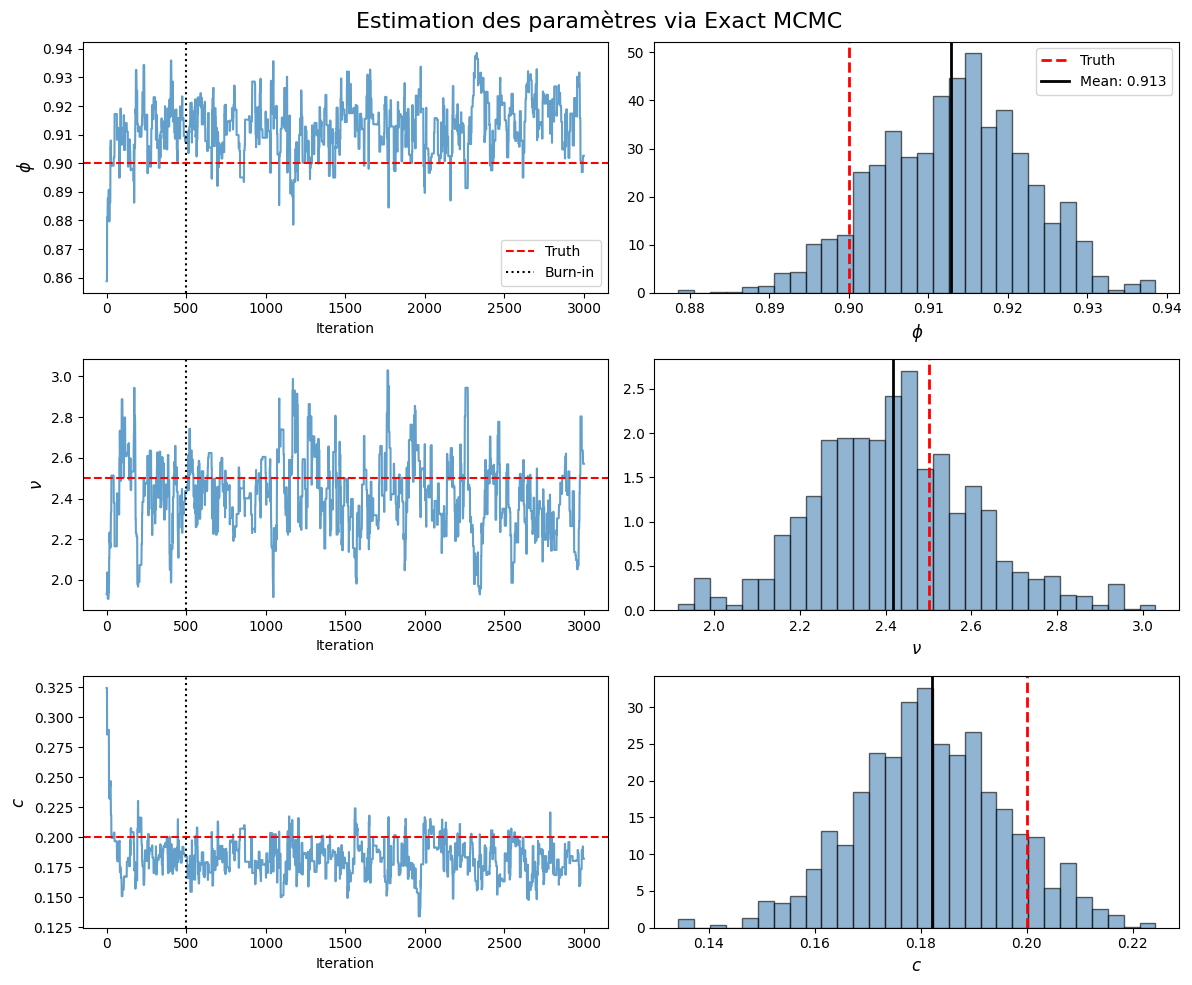

In [8]:
# ==============================================================================
# 4. VISUALISATION DES RESULTATS
# ==============================================================================

burn_in = 500
clean_samples = posterior_samples[burn_in:]

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
param_names = [r'$\phi$', r'$\nu$', r'$c$']
truths = [TRUE_PARAMS['phi'], TRUE_PARAMS['nu'], TRUE_PARAMS['c']]

print("\n--- 3. Résumé des Estimations ---")
print(f"{'Param':<5} | {'True':<8} | {'Est (Mean)':<10} | {'Std Dev':<10}")
print("-" * 45)

means = np.mean(clean_samples, axis=0)
stds = np.std(clean_samples, axis=0)

for i, (name, true_val) in enumerate(zip(param_names, truths)):
    # Trace plot
    axes[i, 0].plot(posterior_samples[:, i], alpha=0.7)
    axes[i, 0].axhline(true_val, color='r', linestyle='--', label='Truth')
    axes[i, 0].axvline(burn_in, color='k', linestyle=':', label='Burn-in')
    axes[i, 0].set_ylabel(name, fontsize=12)
    axes[i, 0].set_xlabel("Iteration")
    if i == 0: axes[i, 0].legend()
    
    # Histogramme (Densité a posteriori)
    axes[i, 1].hist(clean_samples[:, i], bins=30, density=True, alpha=0.6, color='steelblue', edgecolor='k')
    axes[i, 1].axvline(true_val, color='r', linestyle='--', lw=2, label='Truth')
    axes[i, 1].axvline(means[i], color='k', linestyle='-', lw=2, label=f'Mean: {means[i]:.3f}')
    axes[i, 1].set_xlabel(name, fontsize=12)
    if i == 0: axes[i, 1].legend()

    # Print console
    print(f"{name:<5} | {true_val:<8.3f} | {means[i]:<10.3f} | {stds[i]:<10.3f}")

plt.suptitle("Estimation des paramètres via Exact MCMC", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# 3. EXECUTION DU PIPELINE
# ==============================================================================

# Instanciation MCMC
mcmc = ExactMCMCFast(exact_filter_instance, n_samples=10000)

# Taille des pas (Proposal Std) : A ajuster pour avoir ~30% d'acceptation
# Ordre : [phi_unc, nu_unc, c_unc]
# Point de départ (légèrement décalé de la vérité pour voir la convergence)
# Vérité : [0.9, 2.5, 0.2]
start_params = [0.85, 2.0, 0.3]
rw_step_sizes = [0.15, 0.1, 0.1]

# C'est parti (beaucoup plus vite)
posterior_samples = mcmc.run(start_params, proposal_std=rw_step_sizes)


--- Démarrage MCMC Optimisé (Numba) ---
Samples: 10000 | Z_trunc: 165
Terminé. Taux d'acceptation: 25.48%



--- 3. Résumé des Estimations ---
Param | True     | Est (Mean) | Std Dev   
---------------------------------------------
$\phi$ | 0.900    | 0.913      | 0.009     
$\nu$ | 2.500    | 2.410      | 0.189     
$c$   | 0.200    | 0.183      | 0.015     


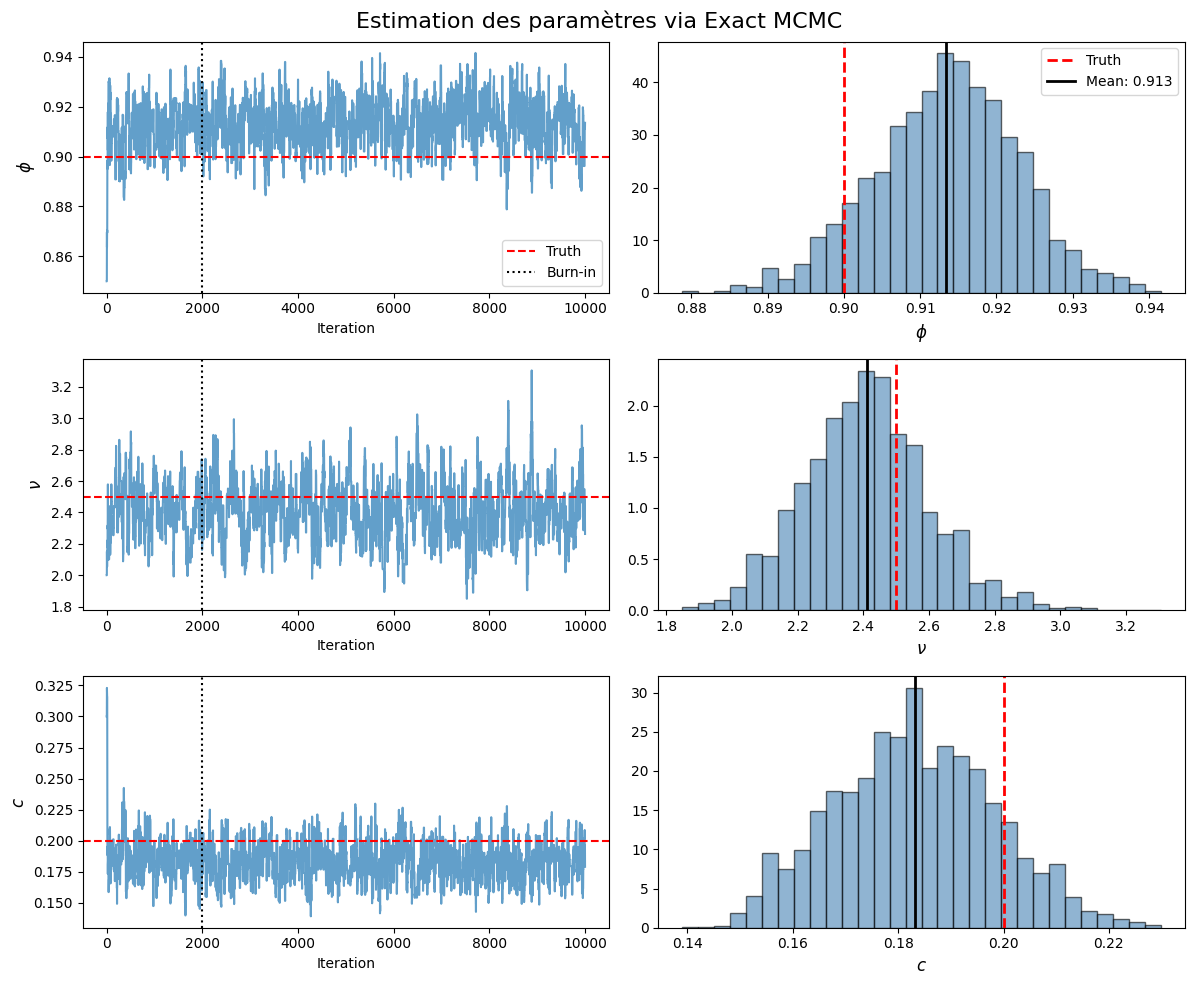

In [ ]:
# ==============================================================================
# 4. VISUALISATION DES RESULTATS
# ==============================================================================

burn_in = 2000
clean_samples = posterior_samples[burn_in:]

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
param_names = [r'$\phi$', r'$\nu$', r'$c$']
truths = [TRUE_PARAMS['phi'], TRUE_PARAMS['nu'], TRUE_PARAMS['c']]

print("\n--- 3. Résumé des Estimations ---")
print(f"{'Param':<5} | {'True':<8} | {'Est (Mean)':<10} | {'Std Dev':<10}")
print("-" * 45)

means = np.mean(clean_samples, axis=0)
stds = np.std(clean_samples, axis=0)

for i, (name, true_val) in enumerate(zip(param_names, truths)):
    # Trace plot
    axes[i, 0].plot(posterior_samples[:, i], alpha=0.7)
    axes[i, 0].axhline(true_val, color='r', linestyle='--', label='Truth')
    axes[i, 0].axvline(burn_in, color='k', linestyle=':', label='Burn-in')
    axes[i, 0].set_ylabel(name, fontsize=12)
    axes[i, 0].set_xlabel("Iteration")
    if i == 0: axes[i, 0].legend()
    
    # Histogramme (Densité a posteriori)
    axes[i, 1].hist(clean_samples[:, i], bins=30, density=True, alpha=0.6, color='steelblue', edgecolor='k')
    axes[i, 1].axvline(true_val, color='r', linestyle='--', lw=2, label='Truth')
    axes[i, 1].axvline(means[i], color='k', linestyle='-', lw=2, label=f'Mean: {means[i]:.3f}')
    axes[i, 1].set_xlabel(name, fontsize=12)
    if i == 0: axes[i, 1].legend()

    # Print console
    print(f"{name:<5} | {true_val:<8.3f} | {means[i]:<10.3f} | {stds[i]:<10.3f}")

plt.suptitle("Estimation des paramètres via Exact MCMC", fontsize=16)
plt.tight_layout()
plt.show()